# Figure 6: Calcium oscillation

In [1]:
using DifferentialEquations
using ModelingToolkit
using MitochondrialDynamics
using MitochondrialDynamics: second, μM, mV, mM, Hz, minute, hil
import PythonPlot as plt
plt.matplotlib.rcParams["font.size"] = 14

14

In [2]:
@named sys = make_model()
@unpack Ca_c, GlcConst, kATPCa, kATP = sys
alg = TRBDF2()

TRBDF2(; linsolve = nothing, nlsolve = OrdinaryDiffEqNonlinearSolve.NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}(1//100, 10, 1//5, 1//5, false, true, 0//1), precs = DEFAULT_PRECS, smooth_est = true, extrapolant = linear, controller = PI, step_limiter! = trivial_limiter!,)

Calcium oscillation function

In [3]:
function cac_wave(; ca_base = 0.09μM, ca_act = 0.25μM, n=4, katp=25, amplitude=0.5, period=2minute)
    @variables t Ca_c(t) ATP_c(t) ADP_c(t)
    @parameters (RestingCa=ca_base, ActivatedCa=ca_act, NCac=n, KatpCac=katp)
    x = 5 * ((t / period) % 1.0) ## An oscillating function
    w = (x * exp(1 - x))^4  ## Scale from 0 to 1
    caceq = Ca_c ~ RestingCa + ActivatedCa * hil(ATP_c, KatpCac * ADP_c, NCac) * (1 + amplitude * (2w-1))
    return caceq
end

@named sysosci = make_model(; caceq=cac_wave(amplitude=0.8))

Model sysosci with 9 equations
Unknowns (9):
  NADH_m(t) [defaults to 0.057]
  NADH_c(t) [defaults to 0.001]
  Ca_m(t) [defaults to 0.0002]
  ΔΨm(t) [defaults to 0.092]
⋮
Parameters (64):
  NCac [defaults to 4]
  ActivatedCa [defaults to 0.00025]
  KatpCac [defaults to 25]
  RestingCa [defaults to 9.0e-5]
⋮

In [4]:
tend = 4000.0
ts = range(tend-480, tend; length=201)
prob = ODEProblem(sysosci, [], tend, [GlcConst => 10mM])
sol = solve(prob, alg, saveat=ts)

retcode: Success
Interpolation: 1st order linear
t: 201-element Vector{Float64}:
 3520.0
 3522.4
 3524.8
 3527.2
 3529.6
 3532.0
 3534.4
 3536.8
 3539.2
 3541.6
    ⋮
 3980.8
 3983.2
 3985.6
 3988.0
 3990.4
 3992.8
 3995.2
 3997.6
 4000.0
u: 201-element Vector{Vector{Float64}}:
 [0.10663925370712568, 0.0031096626353270935, 0.0008340480714225096, 0.12216920919929514, 0.005308719248177244, 0.034742727964047364, 0.9825657172782265, 0.21294081412927773, 0.03089426697951148]
 [0.10715380690566202, 0.003120781524156824, 0.0008280597985221397, 0.12422917394683575, 0.00531389221966499, 0.034922944276474986, 0.9835691005305924, 0.21322745963350612, 0.03097965784346304]
 [0.10777112641020663, 0.003133981571092565, 0.0008189726388351657, 0.12658002124297452, 0.0053196450682061235, 0.03514482204388877, 0.9845936021690224, 0.21343764547694055, 0.031044026884199515]
 [0.1084841088329694, 0.003149075283636527, 0.0008065875422923966, 0.1290805252802413, 0.005325554502885413, 0.03540894195115609, 0.985

In [5]:
function plot_fig5(sol, figsize=(10, 10))
    ts = sol.t
    tsm = ts ./ 60
    @unpack Ca_c, Ca_m, ATP_c, ADP_c, ΔΨm, degavg, J_ANT, J_HL = sys
    fig, ax = plt.subplots(5, 1; figsize)

    ax[0].plot(tsm, sol[Ca_c * 1000], label="Cyto")
    ax[0].plot(tsm, sol[Ca_m * 1000], label="Mito")
    ax[0].set_title("a", loc="left")
    ax[0].set_ylabel("Calcium (μM)", fontsize=12)
    ax[0].legend(loc="center left")

    ax[1].plot(tsm, sol[ATP_c / ADP_c])
    ax[1].set_title("b", loc="left")
    ax[1].set_ylabel("ATP:ADP (ratio)", fontsize=12)

    ax[2].plot(tsm, sol[ΔΨm * 1000])
    ax[2].set_title("c", loc="left")
    ax[2].set_ylabel("ΔΨm (mV)", fontsize=12)

    ax[3].plot(tsm, sol[degavg], label="Average node degree")
    ax[3].set_title("d", loc="left")
    ax[3].set_ylabel("a.u.")
    ax[3].legend(loc="center left")

    ax[4].plot(tsm, sol[J_ANT], label="ATP export")
    ax[4].plot(tsm, sol[J_HL], label="H leak")
    ax[4].set_title("e", loc="left")
    ax[4].set_ylabel("Rate (mM/s)")
    ax[4].set(xlabel="Time (minute)")
    ax[4].legend(loc="center left")

    for i in 0:4
        ax[i].grid()
        ax[i].set_xlim(tsm[begin], tsm[end])
    end

    plt.tight_layout()
    return fig
end

plot_fig5 (generic function with 2 methods)

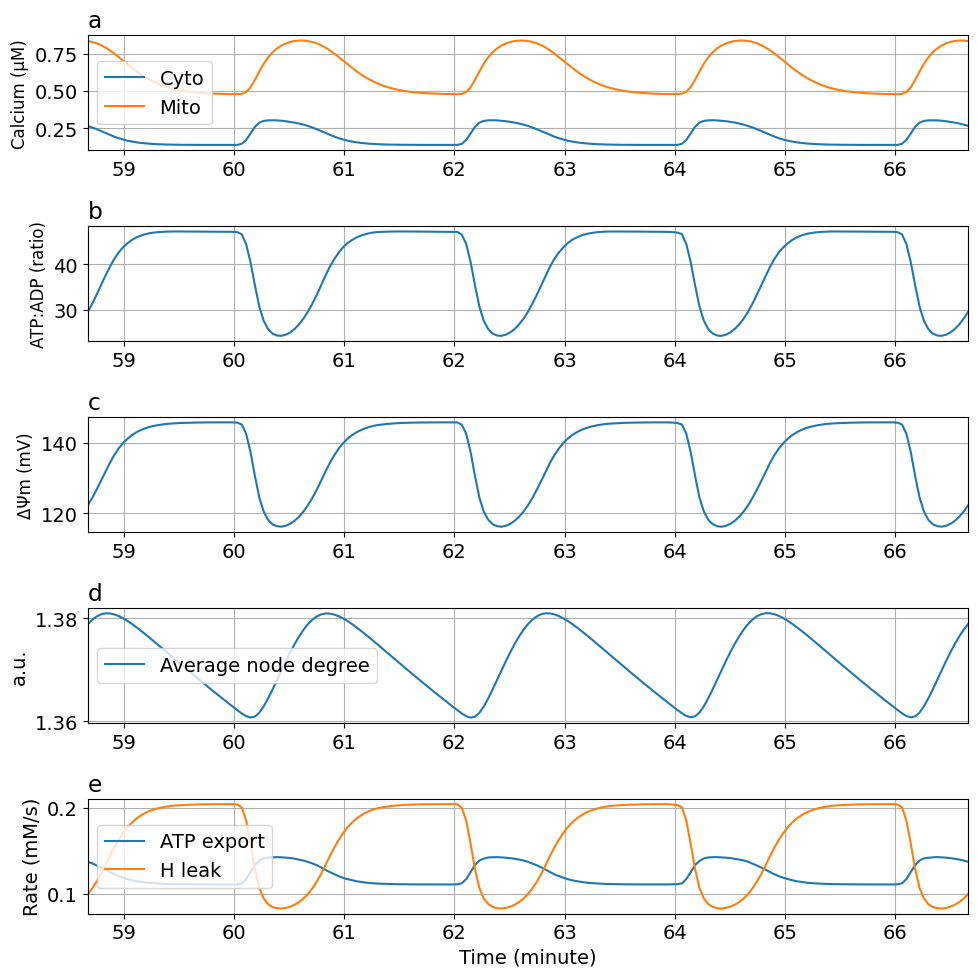

In [6]:
fig5 = plot_fig5(sol)

Export figure

In [7]:
exportTIF(fig5, "Fig6-ca-oscillation.tif")

Python: None

Tuning ca-dependent ATP consumption rate (kATPCa)
kATPCa : 90 -> 10

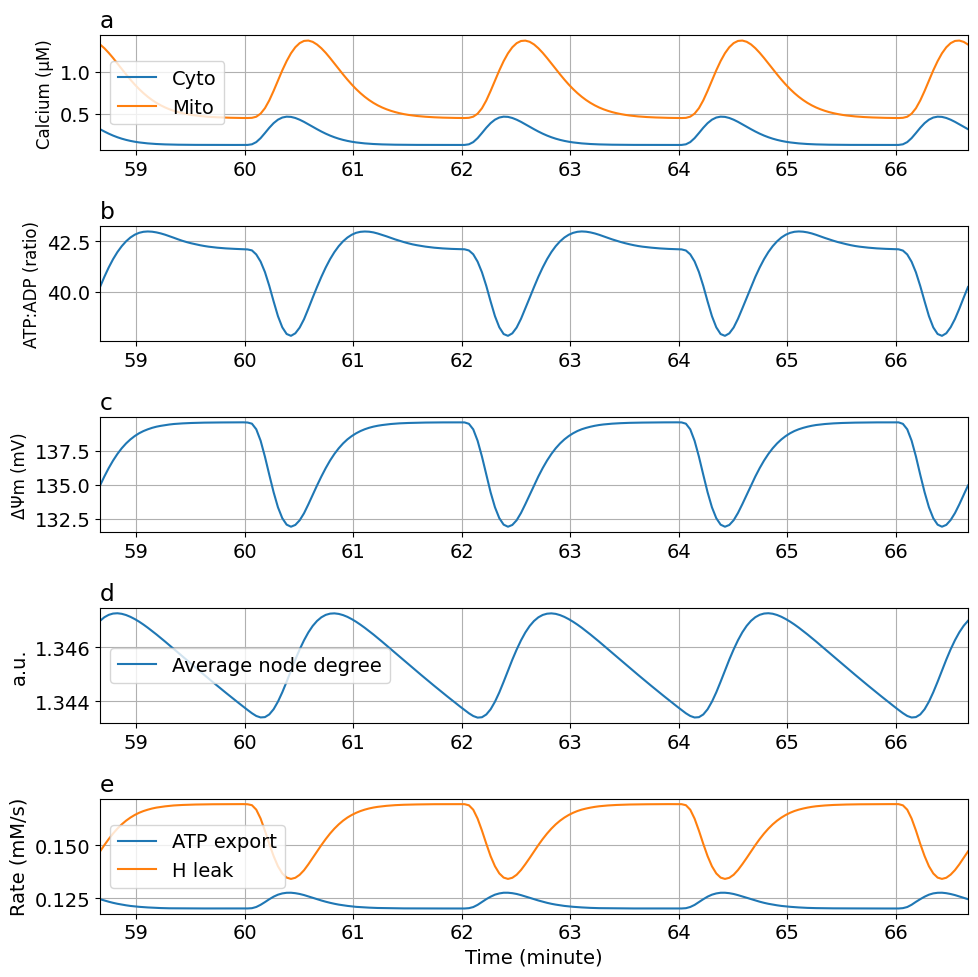

In [8]:
prob2 = ODEProblem(sysosci, [], tend, [GlcConst => 10mM, kATPCa=>10Hz/mM, kATP=>0.055Hz])
sol2 = solve(prob2, alg, saveat=ts)
plot_fig5(sol2)

kATPCa : 90 -> 0.1

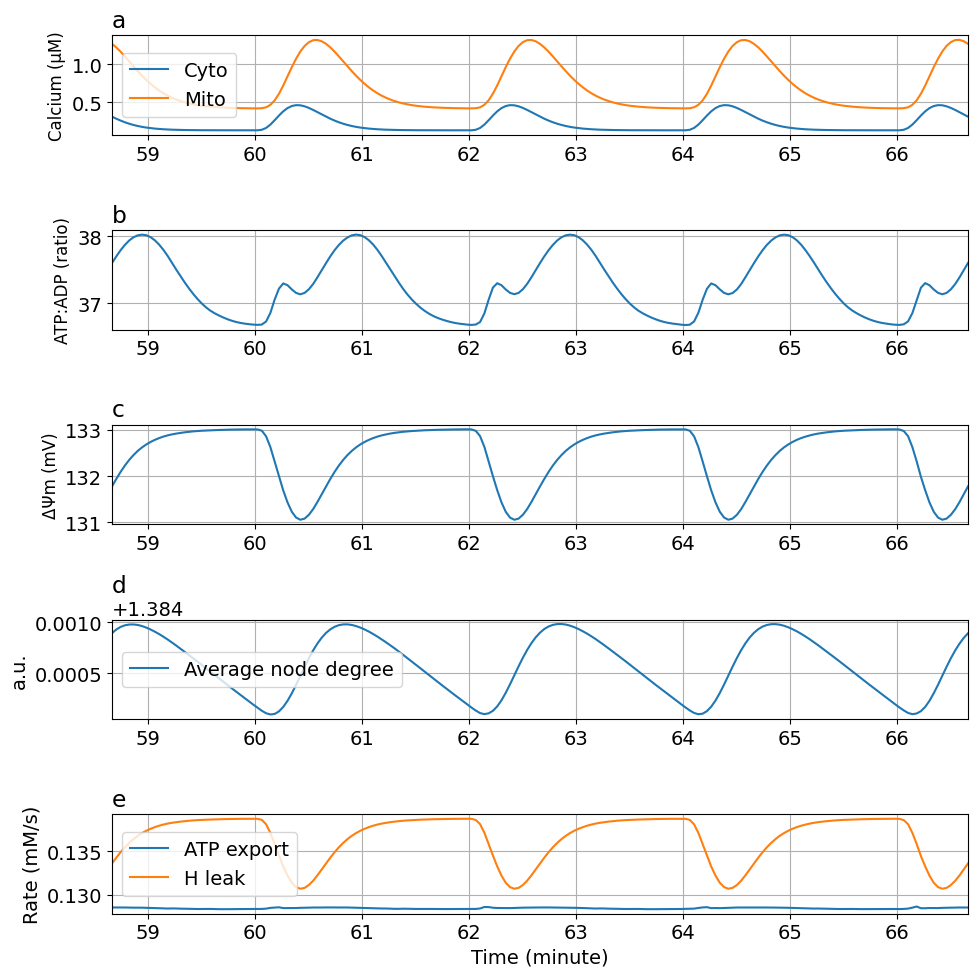

In [9]:
prob4 = ODEProblem(sysosci, [], tend, [GlcConst => 10mM, kATPCa=>0.1Hz/mM, kATP=>0.06Hz])
sol4 = solve(prob4, alg, saveat=ts)
plot_fig5(sol4)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*